# Déterminer quel est le fichier donnant les meilleurs résultats  

* f"animal_faces_{80}x{80}px_carre_{False}_ct_{False}.pkl"
* f"animal_faces_{120}x{120}px_carre_{False}_ct_{False}.pkl"
* f"animal_faces_{80}x{80}px_carre_{True}_ct_{False}.pkl"
* f"animal_faces_{120}x{120}px_carre_{True}_ct_{False}.pkl"
* f"animal_faces_{80}x{80}px_carre_{False}_ct_{True}.pkl"
* f"animal_faces_{120}x{120}px_carre_{False}_ct_{True}.pkl"
* f"animal_faces_{80}x{80}px_carre_{True}_ct_{True}.pkl"
* f"animal_faces_{120}x{120}px_carre_{True}_ct_{True}.pkl"
  
**Conclusions de l'étude:**  
Voir tableau calc (comp_fich.ods, comp_fich.pdf). La découpe carré semble apporté quelques améliorations mais elle ne sont pas régulièrement répartie (dépend des claase). On peut voir que dans le jeux fournis des images sont déformées (redimensionner sans ce préoccuper des déformations induites). Une analyse plus fine de la qualité du jeux d'entrainement devrai permettre d'améliorer de façon notable les résultats.  
Il me manque du temps pour explorer cette piste.

## Import classes et fonctions

In [1]:
import numpy as np
import pandas as pds

import joblib

import skimage
from skimage.io import imread
from skimage.feature import hog
from skimage.transform import rescale, resize
from skimage import data, color

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt

import os 

import random

from collections import Counter


In [2]:
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [3]:
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(nrows=3)
    fig.set_size_inches(30, 20)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
    #for a in ax:print(a) # c'est quoi les valeur de a ????
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('Valeur absolue.')
    ax[0].set_xlabel("Classe")
    
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('Valeur relative (%)')
    
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()

In [11]:
def comp_fich(fich):
    data = joblib.load(fichier)

    # Problème de "Natural" libellé "Nat" à cause du "[:-4]" dans d_DATA['label'].append(el[:-4])
    for i,el in enumerate(data["label"]):
        if el== "Nat":
            data["label"][i]= "Natural"

    X = np.array(data['data'])
    y = np.array(data['label'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=51165)
    
    # create an instance of each transformer
    grayify = RGB2GrayTransformer()
    hogify = HogTransformer(
        pixels_per_cell=(8,8), 
        cells_per_block=(3,2), 
        orientations=8, 
        block_norm='L2-Hys'
    )
    scalify = StandardScaler()

    # call fit_transform on each transform converting X_train step by step
    X_train_gray = grayify.fit_transform(X_train)
    X_train_hog = hogify.fit_transform(X_train_gray)
    X_train_prepared = scalify.fit_transform(X_train_hog)

    #print(X_train_prepared.shape)

    X_test_gray = grayify.transform(X_test)
    X_test_hog = hogify.transform(X_test_gray)
    X_test_prepared = scalify.transform(X_test_hog)

    clf_SVC = svm.SVC(kernel='linear', class_weight='balanced')
    clf_SVC.fit(X_train_prepared, y_train)    

    y_pred = clf_SVC.predict(X_test_prepared)
    #print(np.array(y_pred == y_test)[:25])
    print('\nPercentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

    # On affiche classification report... mais j'ai aussi besoin du dictionnaire ! d'ou double appel pas propre!
    print(classification_report(y_test, y_pred, target_names= np.unique(y_test)))
    dres= classification_report(y_test, y_pred, target_names= np.unique(y_test), output_dict= True)
    
    dres["fichier"]= fich

    cmx = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cmx)
    
    print('\n', sorted(np.unique(y_test)))   
    
    return dres
    
    

## animal_faces_80x80px_carre_False_ct_False.pkl  
  
**2 minutes environ par fichier pour les 80x80, 4/5 minutes pour les 120x120...**


Percentage correct:  77.14884696016772
              precision    recall  f1-score   support

        Bear       0.44      0.73      0.55        11
         Cat       0.71      0.83      0.77        30
     Chicken       0.78      0.84      0.81        25
         Cow       0.81      0.62      0.70        21
        Deer       1.00      1.00      1.00        24
         Dog       0.67      0.85      0.75        72
        Duck       0.86      0.75      0.80        16
       Eagle       0.86      0.50      0.63        24
    Elephant       0.73      0.73      0.73        15
       Human       0.96      0.96      0.96        24
        Lion       0.66      0.76      0.70        25
      Monkey       0.85      0.77      0.81        22
       Mouse       0.65      0.85      0.73        13
       Panda       1.00      0.92      0.96        25
         Pig       0.56      0.53      0.54        19
      Pigeon       0.86      0.82      0.84        22
      Rabbit       0.93      0.57      0.

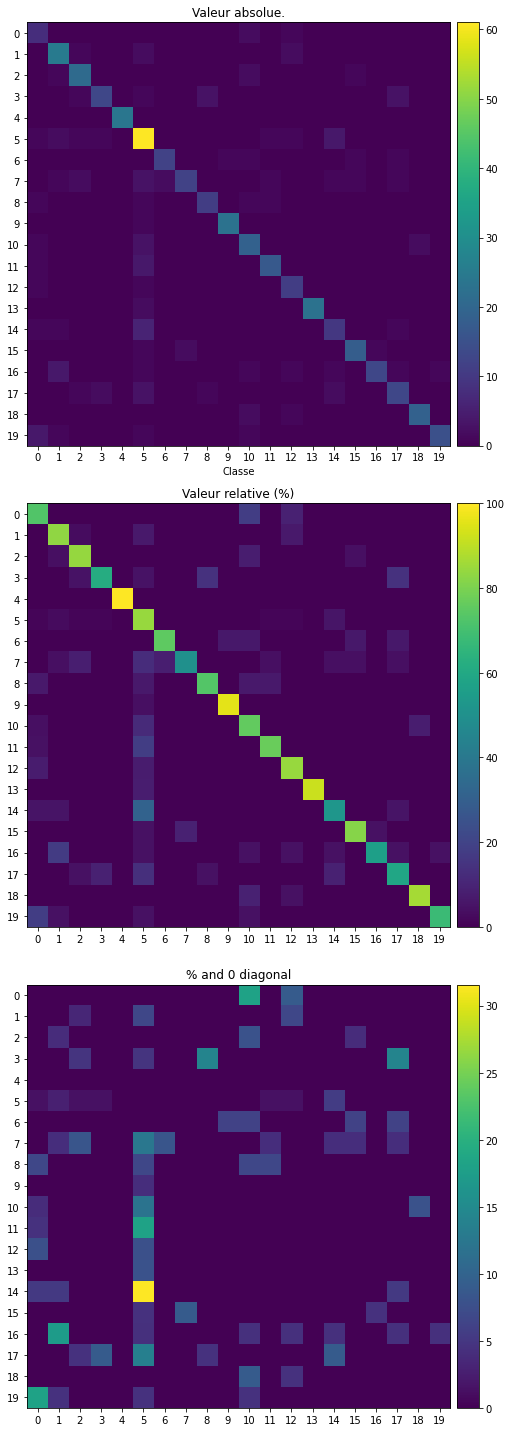

In [12]:
fichier= f"animal_faces_{80}x{80}px_carre_{False}_ct_{False}.pkl"
dresultat80ff= comp_fich(fichier)


In [14]:
#dresultat80ff

## animal_faces_120x120px_carre_False_ct_False.pkl


Percentage correct:  78.40670859538784
              precision    recall  f1-score   support

        Bear       0.53      0.73      0.62        11
         Cat       0.73      0.80      0.76        30
     Chicken       0.83      0.80      0.82        25
         Cow       0.70      0.76      0.73        21
        Deer       0.92      1.00      0.96        24
         Dog       0.64      0.85      0.73        72
        Duck       0.80      0.75      0.77        16
       Eagle       1.00      0.54      0.70        24
    Elephant       0.92      0.73      0.81        15
       Human       0.96      0.96      0.96        24
        Lion       0.78      0.84      0.81        25
      Monkey       0.88      0.64      0.74        22
       Mouse       0.52      0.92      0.67        13
       Panda       1.00      0.92      0.96        25
         Pig       0.91      0.53      0.67        19
      Pigeon       0.79      0.86      0.83        22
      Rabbit       0.93      0.61      0.

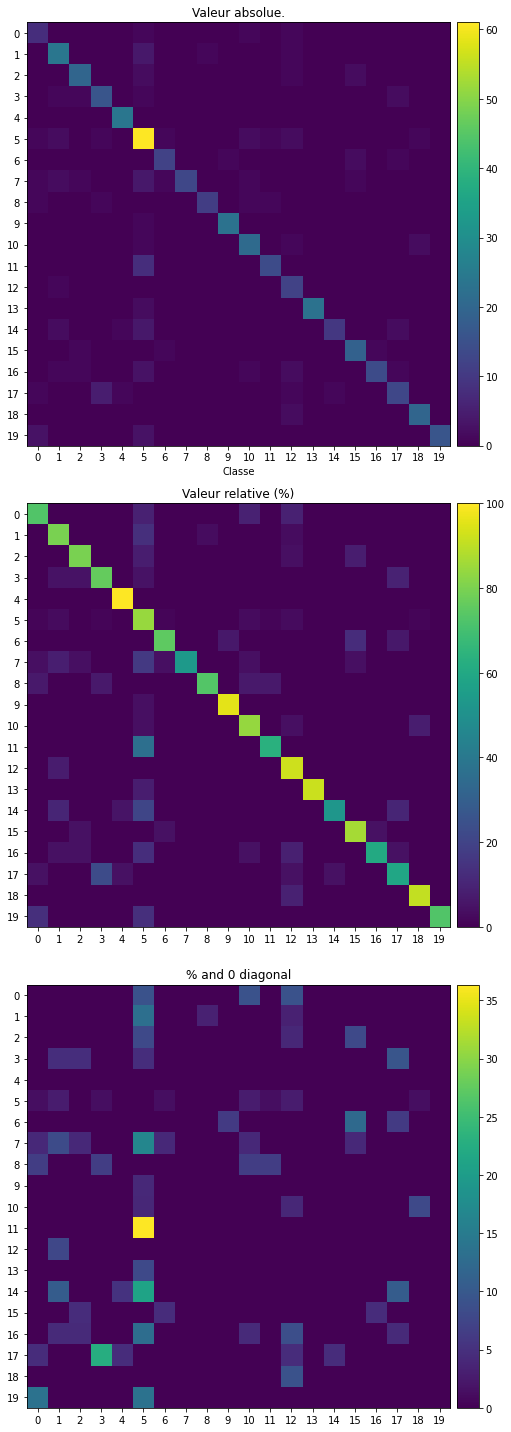

In [15]:
fichier= f"animal_faces_{120}x{120}px_carre_{False}_ct_{False}.pkl"
dresultat120ff= comp_fich(fichier)


## animal_faces_80x80px_carre_True_ct_False.pkl


Percentage correct:  77.77777777777777
              precision    recall  f1-score   support

        Bear       0.54      0.64      0.58        11
         Cat       0.70      0.87      0.78        30
     Chicken       0.81      0.88      0.85        25
         Cow       0.79      0.52      0.63        21
        Deer       0.88      0.96      0.92        24
         Dog       0.71      0.82      0.76        72
        Duck       1.00      0.69      0.81        16
       Eagle       0.94      0.67      0.78        24
    Elephant       0.61      0.73      0.67        15
       Human       0.92      1.00      0.96        24
        Lion       0.74      0.80      0.77        25
      Monkey       0.86      0.82      0.84        22
       Mouse       0.50      0.85      0.63        13
       Panda       1.00      0.88      0.94        25
         Pig       0.56      0.47      0.51        19
      Pigeon       0.83      0.91      0.87        22
      Rabbit       0.88      0.61      0.

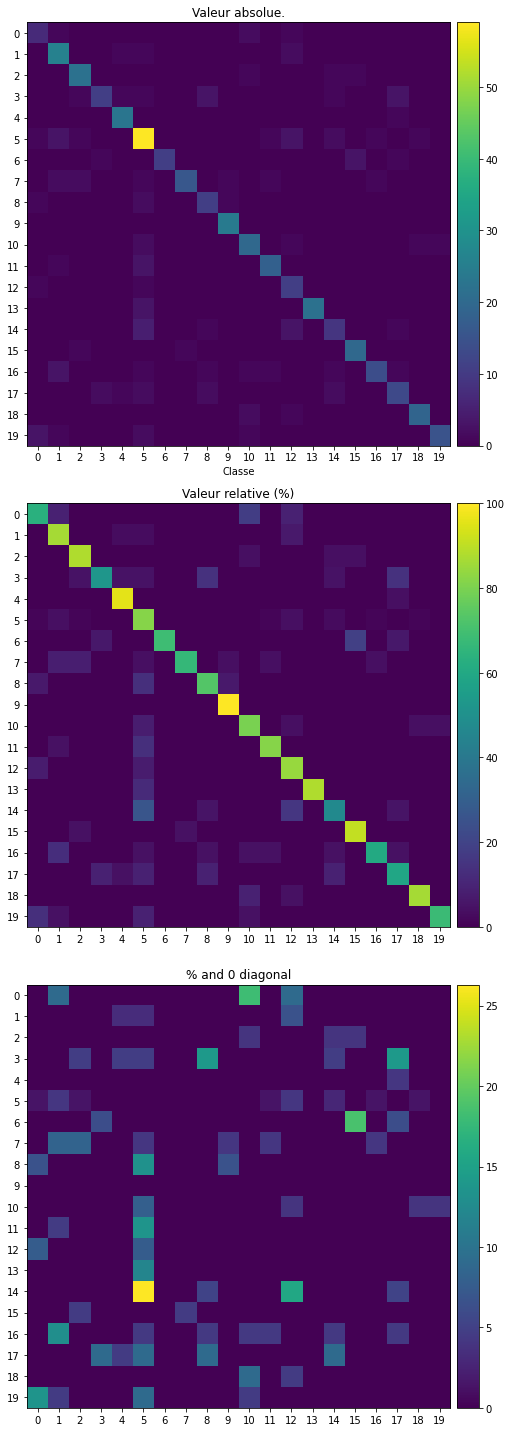

In [16]:
fichier= f"animal_faces_{80}x{80}px_carre_{True}_ct_{False}.pkl"
dresultat80tf= comp_fich(fichier)


## animal_faces_120x120px_carre_True_ct_False.pkl 


Percentage correct:  79.24528301886792
              precision    recall  f1-score   support

        Bear       0.57      0.73      0.64        11
         Cat       0.81      0.83      0.82        30
     Chicken       0.85      0.88      0.86        25
         Cow       0.79      0.71      0.75        21
        Deer       0.89      1.00      0.94        24
         Dog       0.62      0.85      0.72        72
        Duck       0.75      0.75      0.75        16
       Eagle       0.94      0.71      0.81        24
    Elephant       0.92      0.73      0.81        15
       Human       0.96      1.00      0.98        24
        Lion       0.78      0.72      0.75        25
      Monkey       0.82      0.64      0.72        22
       Mouse       0.54      1.00      0.70        13
       Panda       1.00      0.88      0.94        25
         Pig       0.85      0.58      0.69        19
      Pigeon       0.90      0.82      0.86        22
      Rabbit       1.00      0.61      0.

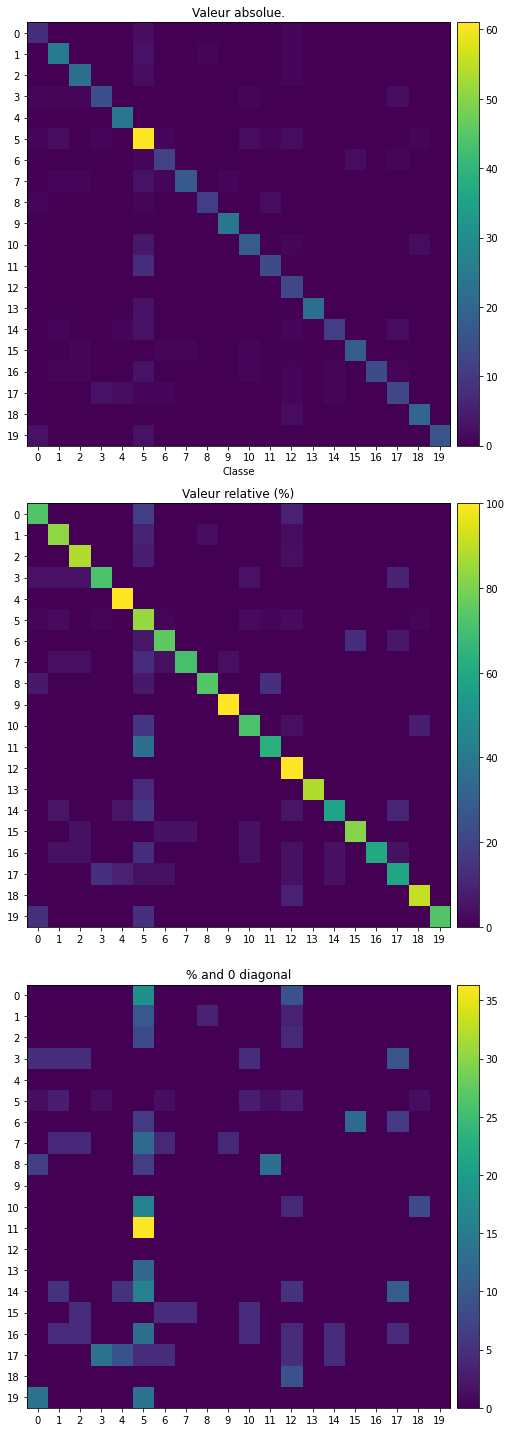

In [17]:
fichier= f"animal_faces_{120}x{120}px_carre_{True}_ct_{False}.pkl"
dresultat120tf= comp_fich(fichier)


## animal_faces_80x80px_carre_False_ct_True.pkl


Percentage correct:  77.35849056603773
              precision    recall  f1-score   support

        Bear       0.50      0.64      0.56        11
         Cat       0.65      0.87      0.74        30
     Chicken       0.81      0.84      0.82        25
         Cow       0.76      0.76      0.76        21
        Deer       1.00      1.00      1.00        24
         Dog       0.68      0.85      0.75        72
        Duck       0.86      0.75      0.80        16
       Eagle       0.86      0.50      0.63        24
    Elephant       0.69      0.73      0.71        15
       Human       0.96      0.96      0.96        24
        Lion       0.73      0.76      0.75        25
      Monkey       0.77      0.77      0.77        22
       Mouse       0.75      0.92      0.83        13
       Panda       0.96      0.88      0.92        25
         Pig       0.57      0.42      0.48        19
      Pigeon       0.78      0.82      0.80        22
      Rabbit       0.93      0.57      0.

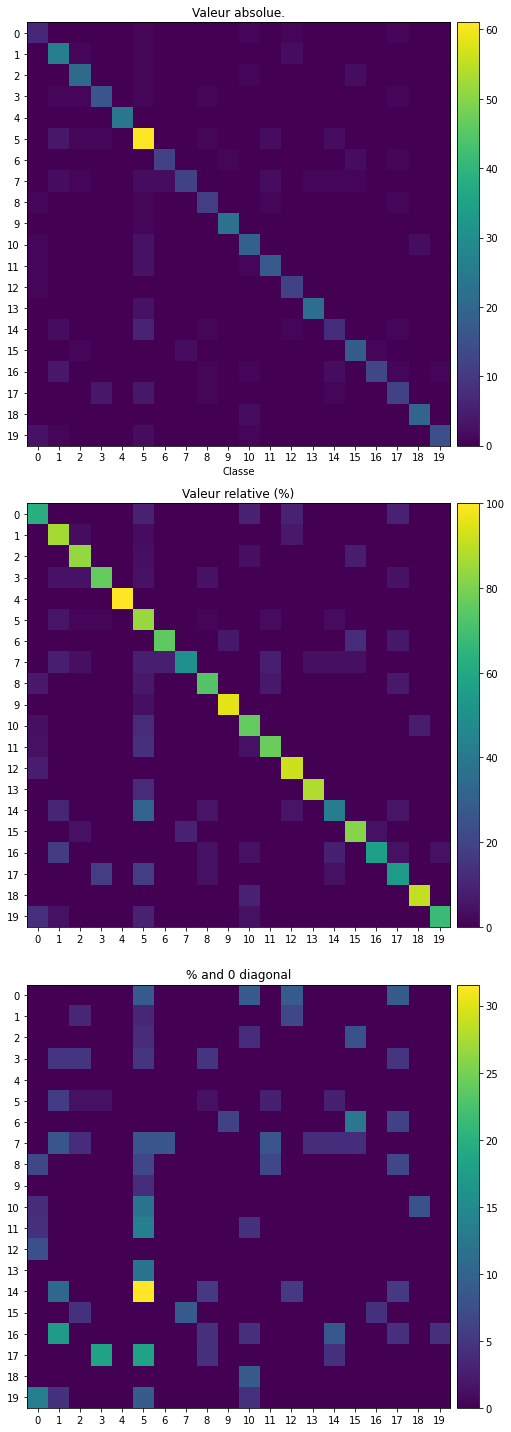

In [18]:
fichier= f"animal_faces_{80}x{80}px_carre_{False}_ct_{True}.pkl"
dresultat80ft= comp_fich(fichier)


## animal_faces_120x120px_carre_False_ct_True.pkl


Percentage correct:  78.82599580712788
              precision    recall  f1-score   support

        Bear       0.54      0.64      0.58        11
         Cat       0.70      0.77      0.73        30
     Chicken       0.88      0.84      0.86        25
         Cow       0.70      0.76      0.73        21
        Deer       0.96      1.00      0.98        24
         Dog       0.64      0.85      0.73        72
        Duck       0.73      0.69      0.71        16
       Eagle       0.92      0.50      0.65        24
    Elephant       0.92      0.73      0.81        15
       Human       0.96      0.96      0.96        24
        Lion       0.77      0.80      0.78        25
      Monkey       0.88      0.64      0.74        22
       Mouse       0.59      1.00      0.74        13
       Panda       0.92      0.92      0.92        25
         Pig       0.92      0.58      0.71        19
      Pigeon       0.80      0.91      0.85        22
      Rabbit       1.00      0.65      0.

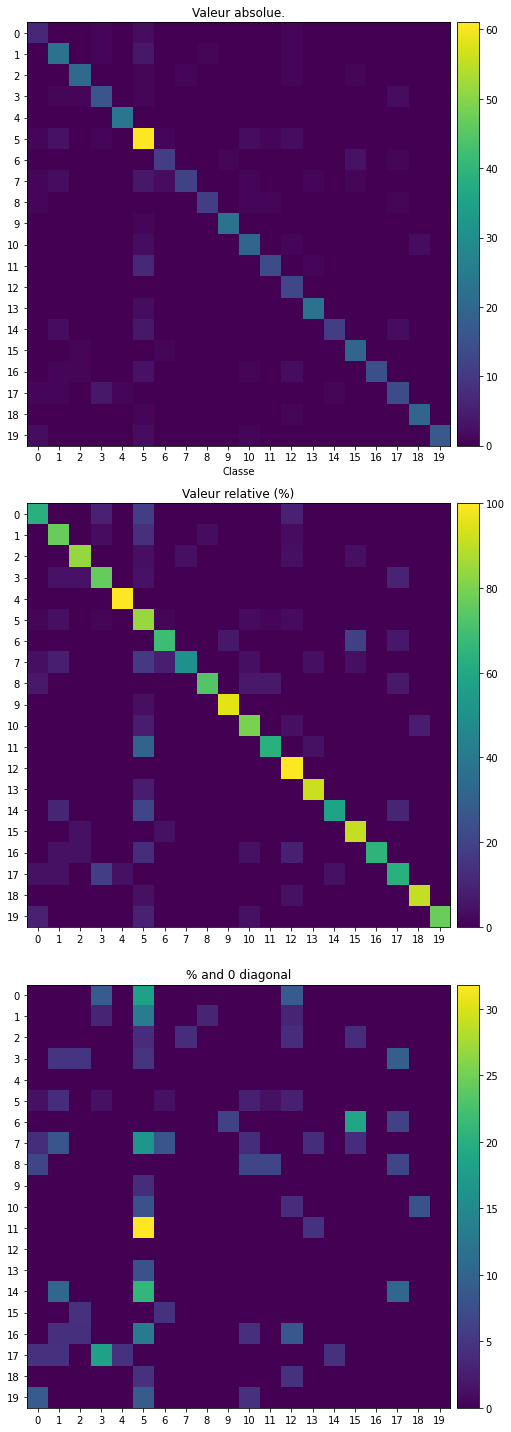

In [19]:
fichier= f"animal_faces_{120}x{120}px_carre_{False}_ct_{True}.pkl"
dresultat120ft= comp_fich(fichier)


## animal_faces_80x80px_carre_True_ct_True.pkl


Percentage correct:  77.77777777777777
              precision    recall  f1-score   support

        Bear       0.50      0.55      0.52        11
         Cat       0.70      0.87      0.78        30
     Chicken       0.81      0.88      0.85        25
         Cow       0.75      0.71      0.73        21
        Deer       0.92      0.96      0.94        24
         Dog       0.74      0.86      0.79        72
        Duck       1.00      0.75      0.86        16
       Eagle       0.83      0.62      0.71        24
    Elephant       0.65      0.73      0.69        15
       Human       0.89      1.00      0.94        24
        Lion       0.74      0.80      0.77        25
      Monkey       0.86      0.82      0.84        22
       Mouse       0.48      0.92      0.63        13
       Panda       1.00      0.88      0.94        25
         Pig       0.50      0.32      0.39        19
      Pigeon       0.85      0.77      0.81        22
      Rabbit       0.88      0.61      0.

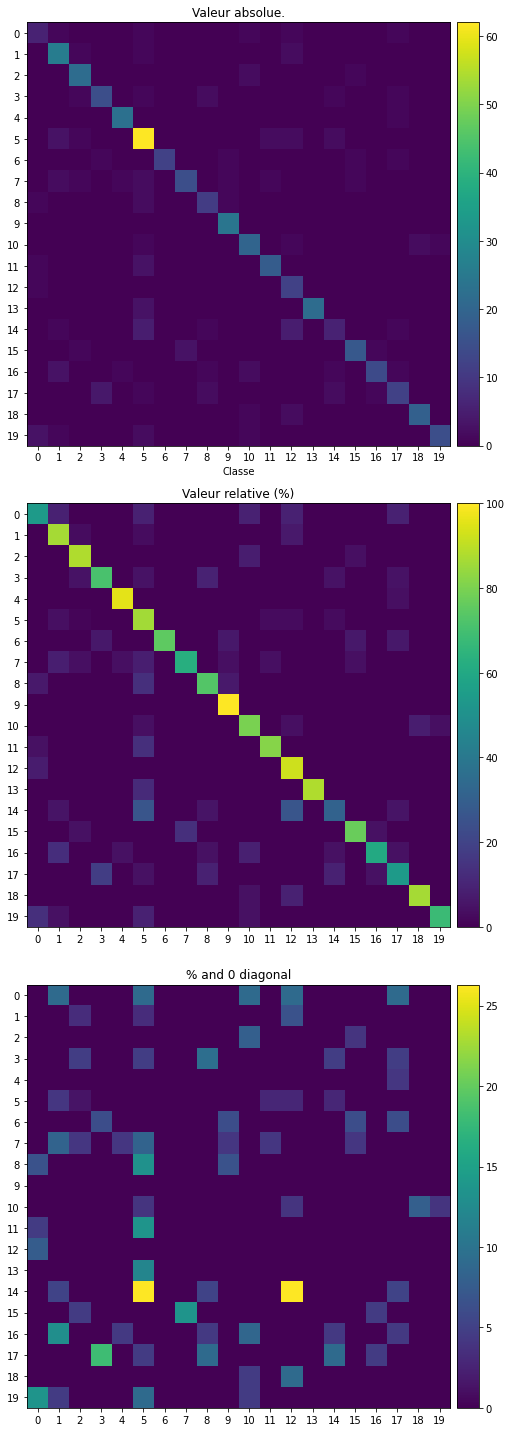

In [20]:
fichier= f"animal_faces_{80}x{80}px_carre_{True}_ct_{True}.pkl"
dresultat80tt= comp_fich(fichier)


## animal_faces_120x120px_carre_True_ct_True.pkl


Percentage correct:  77.35849056603773
              precision    recall  f1-score   support

        Bear       0.55      0.55      0.55        11
         Cat       0.73      0.80      0.76        30
     Chicken       0.78      0.84      0.81        25
         Cow       0.67      0.67      0.67        21
        Deer       0.92      1.00      0.96        24
         Dog       0.63      0.83      0.72        72
        Duck       0.80      0.75      0.77        16
       Eagle       0.94      0.67      0.78        24
    Elephant       0.85      0.73      0.79        15
       Human       0.96      1.00      0.98        24
        Lion       0.69      0.72      0.71        25
      Monkey       0.78      0.64      0.70        22
       Mouse       0.54      1.00      0.70        13
       Panda       0.96      0.88      0.92        25
         Pig       0.83      0.53      0.65        19
      Pigeon       0.90      0.82      0.86        22
      Rabbit       0.93      0.61      0.

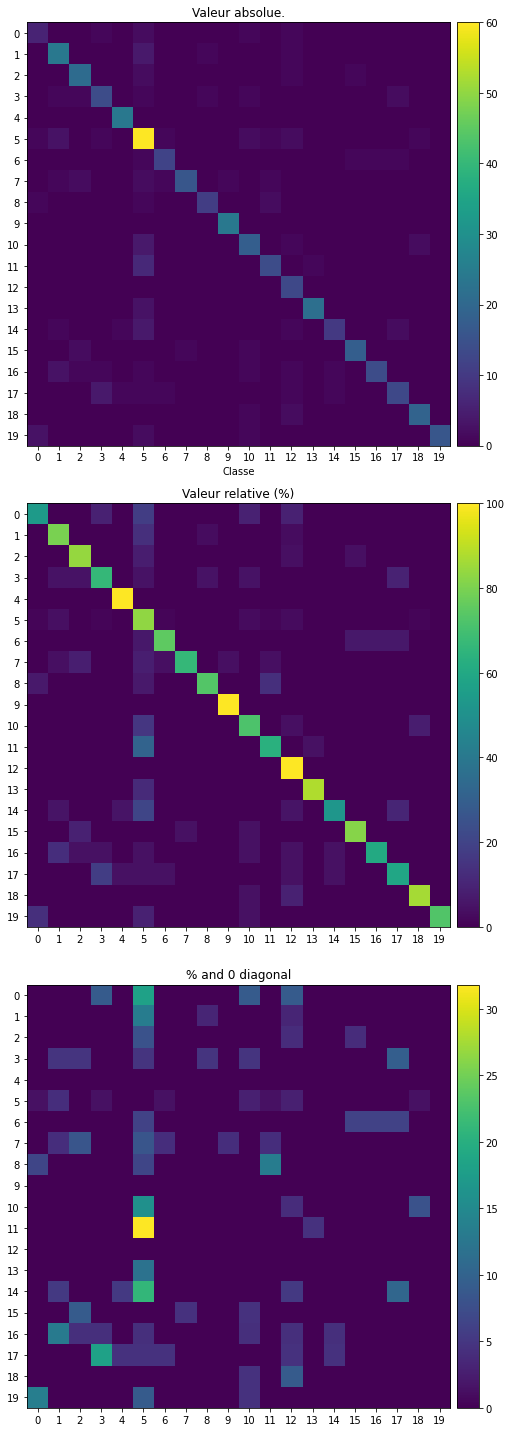

In [21]:
fichier= f"animal_faces_{120}x{120}px_carre_{True}_ct_{True}.pkl"
dresultat120tt= comp_fich(fichier)
